# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is train LSTM model 

#### Import python library

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model 

import pickle
import joblib


In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Define Variables

In [50]:
seed = 7
np.random.seed(seed)
modelname   = 'LSTM1-3in2out_sorted_normalised'
batch_size  = 1024
no_of_epoch = 20
no_of_train = 0.8

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 3, 2

### Define Function

In [45]:
def createModel(): 
    inputs  = Input(shape=(X_train.shape[1],X_train.shape[2]))
    y = LSTM(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(inputs)
    y = BatchNormalization()(y)
    y = LSTM(1024, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(y)
    y = BatchNormalization()(y)
    y = LSTM(1024, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(y)
    y = BatchNormalization()(y)
    y = LSTM(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.4)(y)
    y = BatchNormalization()(y)
    y = LSTM(512, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = LSTM(128, dropout=0.5,recurrent_dropout=0.5)(y)
    y = BatchNormalization()(y)
    y = Dense(predict_next_no_of_output, activation='sigmoid')(y)
  
    model = Model(inputs=inputs,outputs=y)
    model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])
    return model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# normalisation of data
def norm(x):
    data = pd.read_excel('data/normalisation_mean_std.xlsx', sheet_name='Normalised', index_col=0)
    mean = data['mean']
    std  = data['std']
    
    return (x - mean) / std

#### Reading from Preprocessed dataset

In [5]:
xls  = pd.ExcelFile('data/Dataset_feature_sorted_normalised.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')
data

,day,hour,min,lat,long,demand
0,-1.723421,-1.500805,-1.338235,0.481907,1.383892,0.021212
1,-1.723421,-1.500805,-1.338235,1.644371,1.490828,0.013217
2,-1.723421,-1.500805,-1.338235,0.094420,-0.968706,0.157956
3,-1.723421,-1.500805,-1.338235,1.160011,-0.327088,0.001262
4,-1.723421,-1.500805,-1.338235,0.385035,-1.396451,0.032721
...,...,...,...,...,...,...
1048570,1.670463,2.015857,1.343362,-0.099324,-0.968706,0.041818
1048571,1.670463,2.015857,1.343362,-0.293068,0.100657,0.061371
1048572,1.670463,2.015857,1.343362,0.385035,0.100657,0.005397
1048573,1.670463,2.015857,1.343362,-1.455532,0.314530,0.001453


In [6]:
predictor_var = ['day', 'hour', 'min', 'lat', 'long']
outcome_var   = 'demand'
no_of_features = len(predictor_var)

In [7]:
data = data[['day', 'hour', 'min', 'lat', 'long','demand']]
data

,day,hour,min,lat,long,demand
0,-1.723421,-1.500805,-1.338235,0.481907,1.383892,0.021212
1,-1.723421,-1.500805,-1.338235,1.644371,1.490828,0.013217
2,-1.723421,-1.500805,-1.338235,0.094420,-0.968706,0.157956
3,-1.723421,-1.500805,-1.338235,1.160011,-0.327088,0.001262
4,-1.723421,-1.500805,-1.338235,0.385035,-1.396451,0.032721
...,...,...,...,...,...,...
1048570,1.670463,2.015857,1.343362,-0.099324,-0.968706,0.041818
1048571,1.670463,2.015857,1.343362,-0.293068,0.100657,0.061371
1048572,1.670463,2.015857,1.343362,0.385035,0.100657,0.005397
1048573,1.670463,2.015857,1.343362,-1.455532,0.314530,0.001453


#### Prepare training & test data
- Since this is a time series dataset, we can try using LSTM 

In [8]:
dataset = data.to_numpy()
dataset

array([[-1.72342100e+00, -1.50080507e+00, -1.33823457e+00,
         4.81907401e-01,  1.38389211e+00,  2.12124070e-02],
       [-1.72342100e+00, -1.50080507e+00, -1.33823457e+00,
         1.64437101e+00,  1.49082837e+00,  1.32167260e-02],
       [-1.72342100e+00, -1.50080507e+00, -1.33823457e+00,
         9.44195313e-02, -9.68705602e-01,  1.57956413e-01],
       ...,
       [ 1.67046336e+00,  2.01585687e+00,  1.34336210e+00,
         3.85035434e-01,  1.00656996e-01,  5.39676900e-03],
       [ 1.67046336e+00,  2.01585687e+00,  1.34336210e+00,
        -1.45553195e+00,  3.14529515e-01,  1.45313800e-03],
       [ 1.67046336e+00,  2.01585687e+00,  1.34336210e+00,
        -4.86812273e-01,  1.06308333e+00,  1.41995720e-01]])

In [9]:
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
print(X.shape, y.shape)

(1048572, 3, 5) (1048572, 2)


In [10]:
# summarize the data
for i in range(3):
    print(X[i], y[i])

[[-1.723421   -1.50080507 -1.33823457  0.4819074   1.38389211]
 [-1.723421   -1.50080507 -1.33823457  1.64437101  1.49082837]
 [-1.723421   -1.50080507 -1.33823457  0.09441953 -0.9687056 ]] [0.15795641 0.00126166]
[[-1.723421   -1.50080507 -1.33823457  1.64437101  1.49082837]
 [-1.723421   -1.50080507 -1.33823457  0.09441953 -0.9687056 ]
 [-1.723421   -1.50080507 -1.33823457  1.16001117 -0.32708804]] [0.00126166 0.03272106]
[[-1.723421   -1.50080507 -1.33823457  0.09441953 -0.9687056 ]
 [-1.723421   -1.50080507 -1.33823457  1.16001117 -0.32708804]
 [-1.723421   -1.50080507 -1.33823457  0.38503543 -1.39645064]] [0.03272106 0.03925688]


#### Train-test-val dataset split

In [11]:
X_train1 = X[:int(no_of_train*len(X))]
y_train1 = y[:int(no_of_train*len(X))]
X_test  = X[int(no_of_train*len(X)):]
y_test  = y[int(no_of_train*len(X)):]

X_train = X_train1[:int(no_of_train*len(X_train1))]
y_train = y_train1[:int(no_of_train*len(X_train1))]
X_val   = X_train1[int(no_of_train*len(X_train1)):]
y_val   = y_train1[int(no_of_train*len(X_train1)):]

In [12]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(671085, 3, 5) (671085, 2) (209715, 3, 5) (209715, 2) (167772, 3, 5) (167772, 2)


<h2><center>Create Model and test</center><h2>

<h3>LSTM<h3>

In [46]:
model = createModel()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 5)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 64)             17920     
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 64)             256       
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 1024)           4460544   
_________________________________________________________________
batch_normalization_7 (Batch (None, 3, 1024)           4096      
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 1024)           4096

In [47]:
model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])

In [48]:
# Create checkpoints to save model during training and save training data into csv
# ‘monitor’ can be ‘val_acc’ or ‘val_loss’
# When set to ‘val_acc’, ‘mode’ must be ‘max’; when set to ‘val_loss’, ‘mode’ must be ‘min’

filepath       = modelname + ".hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
csv_logger     = CSVLogger(modelname + '.csv')
callbacks_list = [checkpoint,csv_logger]

In [51]:
# The line for training
history = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_val, y_val), 
                     epochs=no_of_epoch, 
                     batch_size=batch_size,
                     shuffle=False,
                     callbacks=callbacks_list) 

Train on 671085 samples, validate on 167772 samples
Epoch 1/20
671085/671085 [==============================] - 90s 134us/sample - loss: 0.0414 - mse: 0.0414 - mae: 0.1307 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1033
Epoch 2/20
671085/671085 [==============================] - 89s 133us/sample - loss: 0.0244 - mse: 0.0244 - mae: 0.0951 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1015
Epoch 3/20
671085/671085 [==============================] - 89s 133us/sample - loss: 0.0244 - mse: 0.0244 - mae: 0.0951 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1030
Epoch 4/20
671085/671085 [==============================] - 91s 135us/sample - loss: 0.0244 - mse: 0.0244 - mae: 0.0951 - val_loss: 0.0250 - val_mse: 0.0250 - val_mae: 0.1041
Epoch 5/20
671085/671085 [==============================] - 91s 136us/sample - loss: 0.0244 - mse: 0.0244 - mae: 0.0951 - val_loss: 0.0251 - val_mse: 0.0251 - val_mae: 0.1041
Epoch 6/20
671085/671085 [==============================] - 91s 136us/sam

### Test dataset test result

In [52]:
predicted_value = model.predict(X_test)
print(mean_squared_error(y_test,predicted_value))

0.028873923463451252


KeyError: 'val_mae'

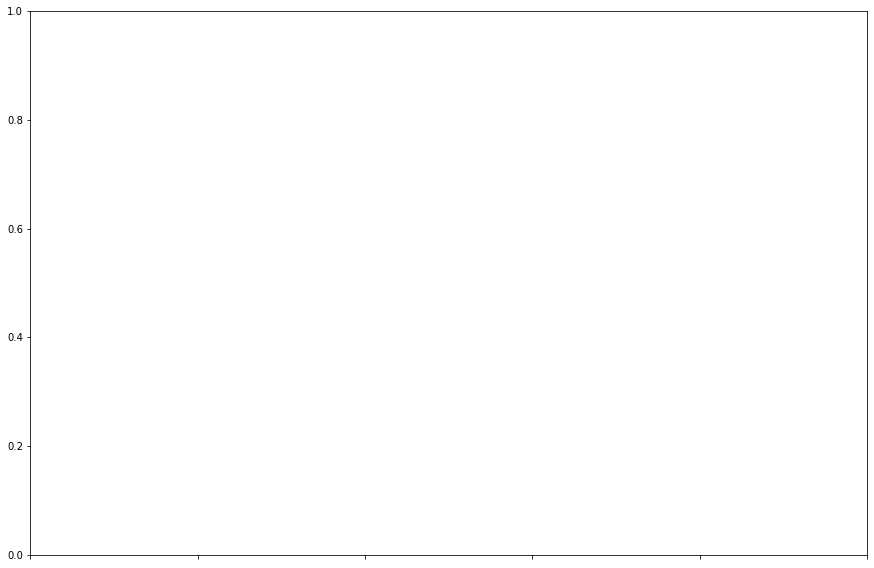

In [53]:
records     = pd.read_csv(modelname +'.csv')
plt.figure(figsize=(15,10))

ax          = plt.gca()
ax.set_xticklabels([])

plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.plot(records['loss'],label="loss")
plt.title('MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()

### Load saved trained model and scalar

In [61]:
# Load your own trained model & scaler
model           = load_model(filepath, compile = False)
scaler_filename = "grab_msft_sorted_scaler.save"
scaler          = joblib.load(scaler_filename) 

### Sample Testing 

In [55]:
xls  = pd.ExcelFile('data/test_sample_sorted_8000.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')

# Apply normalisation to sample test data
test_sample[['day','hour','min','lat','long']] = norm(test_sample[['day','hour','min','lat','long']])

In [56]:
# covert into input/output
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(18, 3, 5) (18, 2)


In [57]:
predicted_value = model.predict(X_sample)
print('Predicted value : {} \n Actual Value    : {}' .format(predicted_value,y_sample))

Predicted value : [[0.10917372 0.11170594]
 [0.12884027 0.12812077]
 [0.12884027 0.1281208 ]
 [0.12884022 0.12812074]
 [0.12882563 0.12809661]
 [0.12884027 0.12812078]
 [0.1288399  0.12812017]
 [0.12884018 0.12812065]
 [0.12884018 0.12812065]
 [0.12884021 0.12812074]
 [0.12884027 0.1281208 ]
 [0.12883875 0.12811829]
 [0.12884013 0.12812056]
 [0.1096923  0.10973983]
 [0.12884021 0.1281207 ]
 [0.11280828 0.11413889]
 [0.11671405 0.11852096]
 [0.12884001 0.12812042]] 
 Actual Value    : [[0.01799946 0.0531276 ]
 [0.0531276  0.10812558]
 [0.10812558 0.03172353]
 [0.03172353 0.08252318]
 [0.08252318 0.64191406]
 [0.64191406 0.13738873]
 [0.13738873 0.20788158]
 [0.20788158 0.23219486]
 [0.23219486 0.00794347]
 [0.00794347 0.00706648]
 [0.00706648 0.28443333]
 [0.28443333 0.67788291]
 [0.67788291 0.15390443]
 [0.15390443 0.01326358]
 [0.01326358 0.06040241]
 [0.06040241 0.03081827]
 [0.03081827 0.04285664]
 [0.04285664 1.        ]]


In [58]:
print(mean_squared_error(y_sample,predicted_value))

0.05927476725770406


### Testing using 1 row of inference data

In [59]:
# Data input sequence format :
test_data1  = [[18,20, 0, -5.353088, 90.653687],
               [10,14,30, -5.413513, 90.664673],
               [ 9, 6,15, -5.325623, 90.906372]]
test_data2  = [[32, 5, 0, -5.353088, 90.752563],
               [15, 4, 0, -5.413513, 90.719604],
               [ 1,12,15, -5.336609, 90.609741]]
test_data3  = [[25, 3,30, -5.391541, 90.818481],
               [51,20,45, -5.408020, 90.631714],
               [48, 6,15, -5.364075, 90.763550]]
test_data4  = [[ 4,22,15, -5.402527, 90.675659],
               [45, 9,15, -5.402527, 90.917358],
               [52,11,45, -5.364075, 90.664673]]
test_data5  = [[46,12,15, -5.353088, 90.642700],
               [34,14,45, -5.375061, 90.807495],
               [40, 2,30, -5.424500, 90.785522]]
test_data6  = [[14,14,45, -5.391541, 90.598755],
               [27, 3,30, -5.320129, 90.785522],
               [ 6,23,45, -5.358582, 90.752563]]

test_target1 = [[0.102821],[0.088755]]
test_target2 = [[0.023843],[0.007460]]
test_target3 = [[0.054170],[0.123463]]
test_target4 = [[0.359406],[0.514136]]
test_target5 = [[0.026409],[0.013998]]
test_target6 = [[0.029400],[0.057255]]

#### First set of testdata

In [62]:
Data_scaled = scaler.transform(test_data1)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target1))

Predicted value : [[0.11125613 0.11028143]]
Actual Value    : [[0.102821], [0.088755]]


In [63]:
Data_scaled = scaler.transform(test_data2)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target2))

Predicted value : [[0.11109656 0.10981342]]
Actual Value    : [[0.023843], [0.00746]]


In [64]:
Data_scaled = scaler.transform(test_data3)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target3))

Predicted value : [[0.12883306 0.1281089 ]]
Actual Value    : [[0.05417], [0.123463]]


In [65]:
Data_scaled = scaler.transform(test_data4)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target4))

Predicted value : [[0.12878662 0.12803216]]
Actual Value    : [[0.359406], [0.514136]]


In [66]:
Data_scaled = scaler.transform(test_data5)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target5))

Predicted value : [[0.11162008 0.11081509]]
Actual Value    : [[0.026409], [0.013998]]


In [67]:
Data_scaled = scaler.transform(test_data6)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target6))

Predicted value : [[0.11143426 0.11305314]]
Actual Value    : [[0.0294], [0.057255]]
